In [3]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['legend.frameon'] = True

#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 50)

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('deep')
import warnings
warnings.filterwarnings('ignore')

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Connected Components Analysis

This section contains the analysis of the size/proportion of the largest connected components.

The first bit of code is for doing the plot of LCC size, proportion and number of components for all windows.

In [4]:
def fullPlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)

    with open('CC/nowindow.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x = x[x['total'] != 0]
        x['mean'] = x[toPlot].rolling(window=4,center=False).mean()
        x.plot(x='time', y=toPlot,ax=ax, label="Aggregate Graph")

    with open('CC/bigCC.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        cc1 = cc1[cc1[toPlot] != 0]
        index = 0
        for i in windows:
            y = cc1[cc1['windowsize'] == i]
            y['mean'] = y[toPlot].rolling(window=4,center=False).mean()
            hours = str(int((i/3600000)))+" hour window"
            y.plot(x='time', y=toPlot,ax=ax, label=labels[index])
            index +=1

    with open('CC/cc1hour.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        #x = x[x['hour'].isin([4,16])]
        x.plot(x='time', y=toPlot,ax=ax, color="#f0134d", label="Hour window")
    ax.legend(fontsize=20,framealpha=0.9,loc='lower right')
    plt.tight_layout()
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.xlabel("Date")
    plt.savefig("Graphs/"+toPlot+"partial.png")
    plt.show()

    
partial_dates = ['2017-09-30 23:00:00','2017-10-30']
full_dates = ['2016-09-30 23:00:00','2018-10-30']
#x['mean'] = x[toPlot].rolling(window=24,center=False).mean()
#[0,4,8,12,16,20,24]
#'2016-07-01': '2018-05-03'

## Connected components: full period

Below are the varaious stats for the full time period (30/09/16 to 05/18) and all windows.

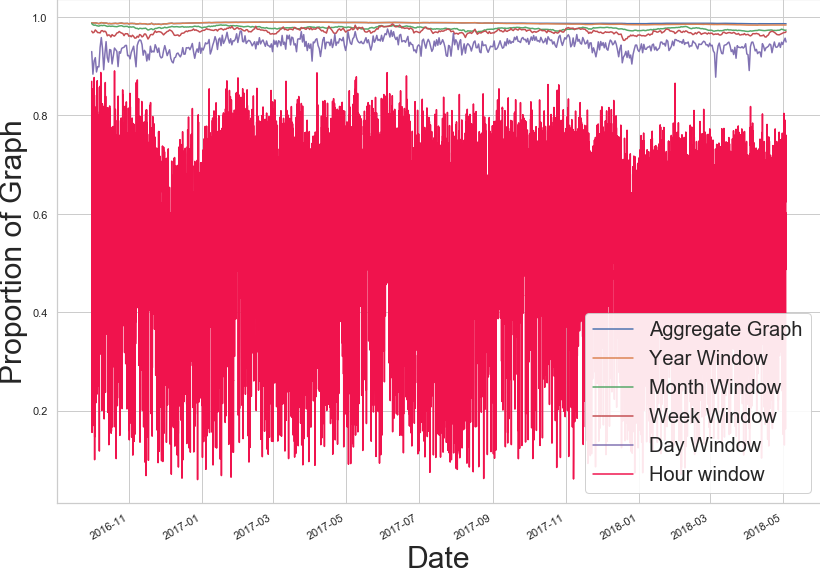

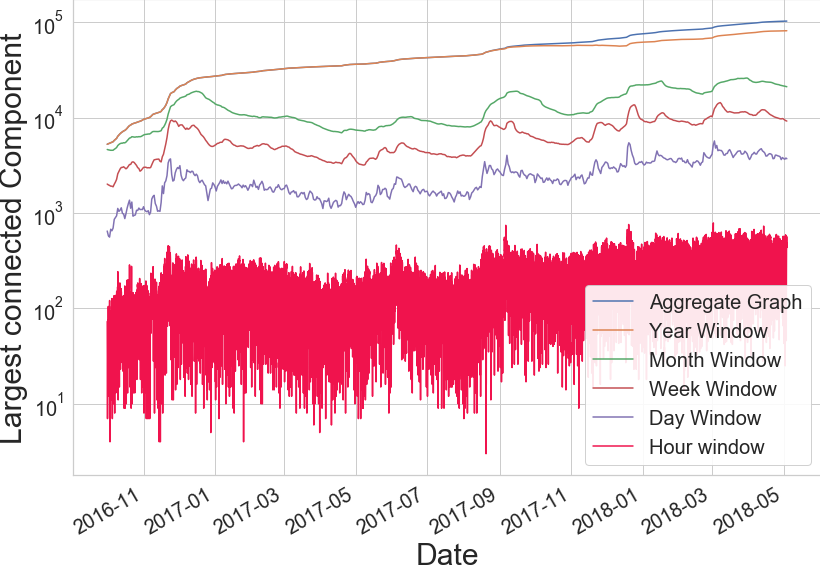

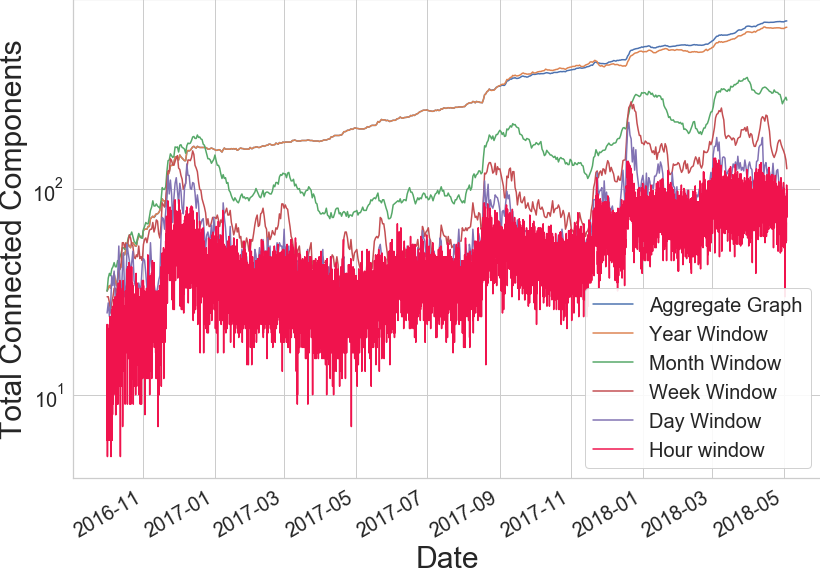

In [5]:
fullPlot('proportionWithoutIslands','Largest Connected Component % of Graph','Date','Proportion of Graph','linear','2016-09-30 23:00:00','2018-10-30')

fullPlot('biggest','Largest Connected Component Size','Date','Largest connected Component','log','2016-09-30 23:00:00','2018-10-30')

fullPlot('totalWithoutIslands','Total Connected Components','Date','Total Connected Components','log','2016-09-30 23:00:00','2018-10-30')

## Connected components: zoomed in 

This is just looking at a month of data (10/2017)

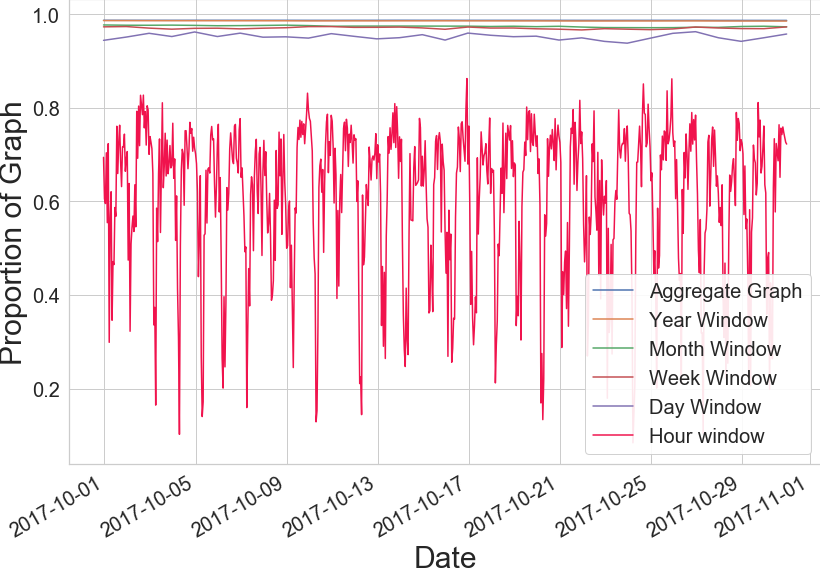

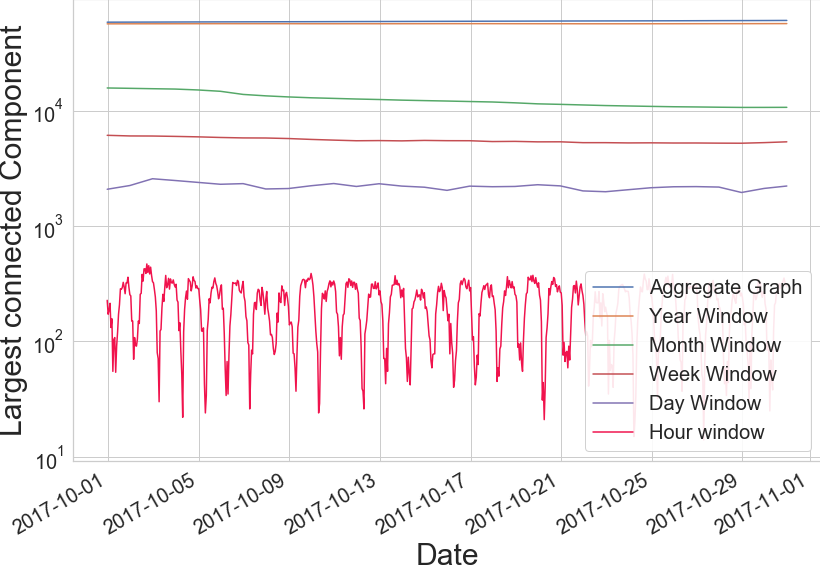

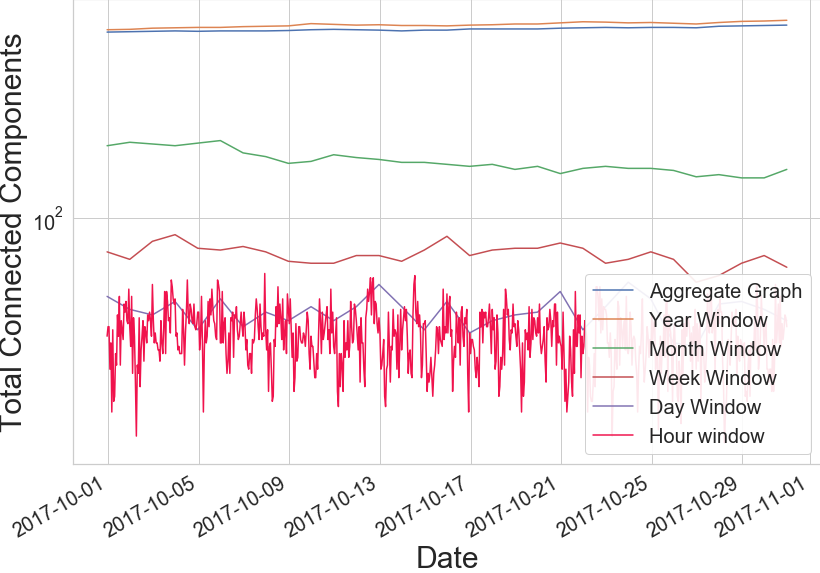

In [6]:
fullPlot('proportionWithoutIslands','Largest Connected Component % of Graph','Date','Proportion of Graph','linear','2017-09-30 23:00:00','2017-10-30')

fullPlot('biggest','Largest Connected Component Size','Date','Largest connected Component','log','2017-09-30 23:00:00','2017-10-30')

fullPlot('totalWithoutIslands','Total Connected Components','Date','Total Connected Components','log','2017-09-30 23:00:00','2017-10-30')

## Connected components with shuffled timestamps

Keep the same links but reorder their timestamps randomly, so that the rate of edge activity is conserved and that the aggregate graph is identical. Do the same measurements.

In [7]:
def nullComparePlot(toPlot,x,y,scale,start,end,window):
    windows = {"Year": 31536000000,"Month": 2592000000, "Week": 604800000, "Day": 86400000}
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)
    
    if window=="Hour":
        with open('CC/cc1hour.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            cc1.plot(x='time', y=toPlot,ax=ax, label="Real Data")
    
        with open('CC/sortedCChour.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            cc1.plot(x='time', y=toPlot,ax=ax, label="Shuffled Timestamps")
            
    else:
        with open('CC/bigCC.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize'] == windows[window]]
            y.plot(x='time', y=toPlot,ax=ax, label="Real Data")

        with open('CC/sortedCC.json') as json_file:
            cc1 = json.load(json_file)
            cc1= pd.DataFrame(cc1['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
            cc1.set_index('index', inplace=True)
            cc1=cc1[start:end]
            cc1 = cc1[cc1[toPlot] != 0]
            y = cc1[cc1['windowsize'] == windows[window]]
            y.plot(x='time', y=toPlot,ax=ax, label="Shuffled Timestamps")
        
    ax.legend(fontsize=20,framealpha=0.9,loc='lower right')
    plt.tight_layout()
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.xlabel("Date")


### Proportion: Hour window

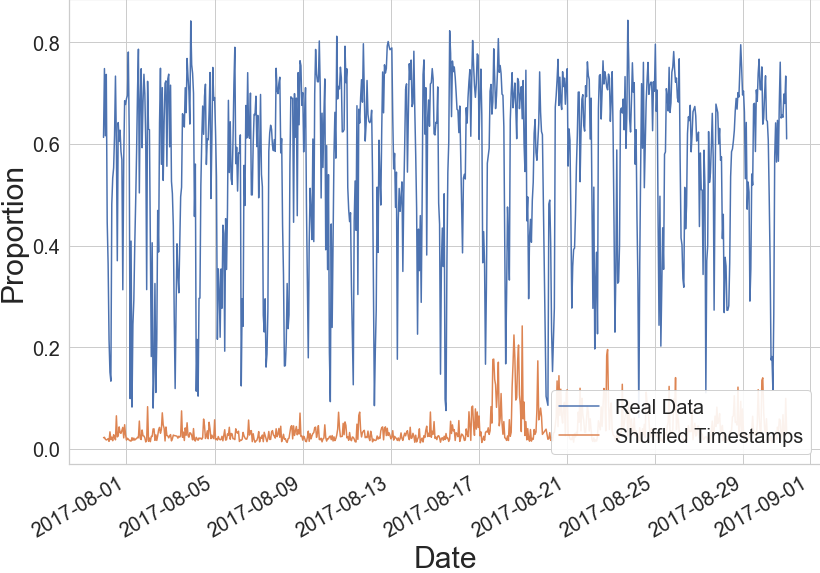

In [31]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2017-07-30 23:00:00','2017-08-30','Hour')

### Proportion: Day window

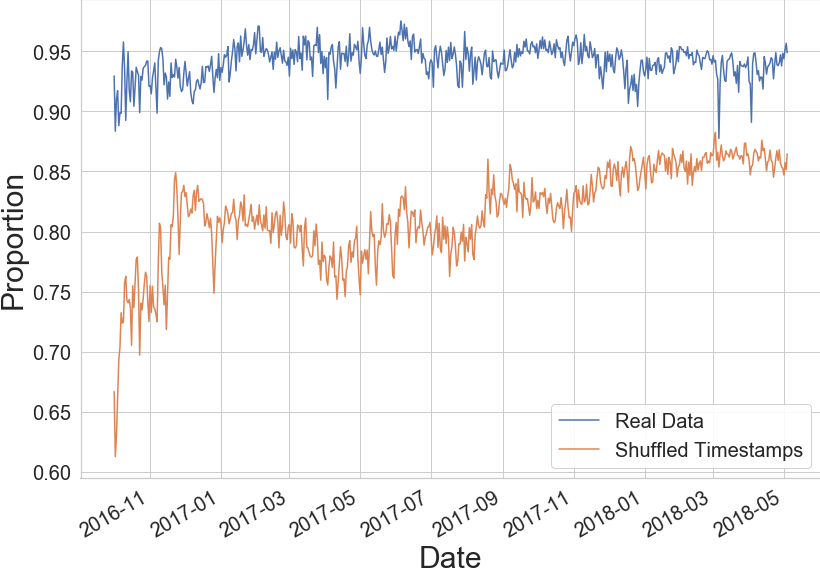

In [32]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Day')

### Proportion: Week Window

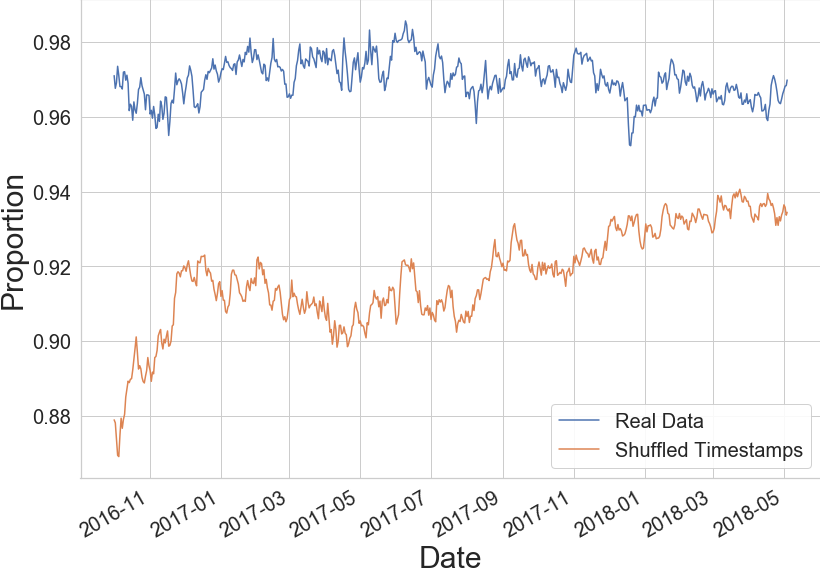

In [30]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Week')

### Proportion: Month window

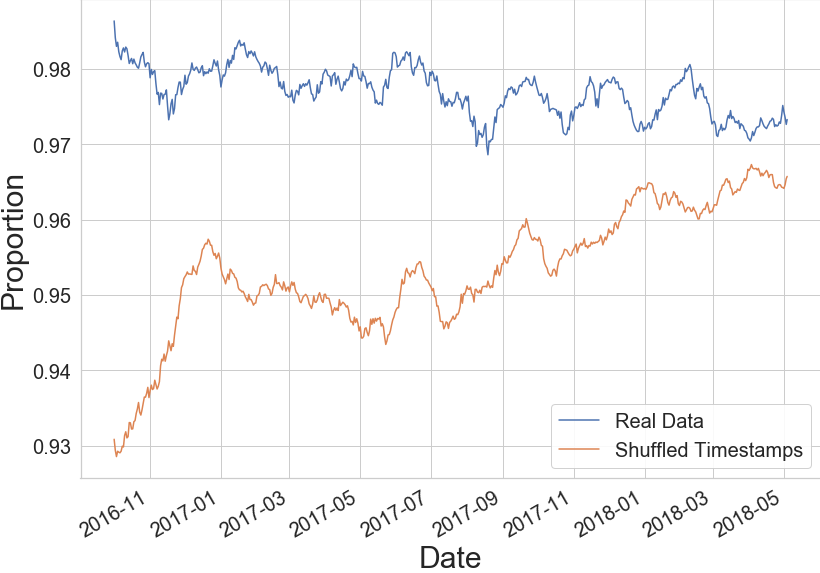

In [33]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Month')

### Proportion: Year window

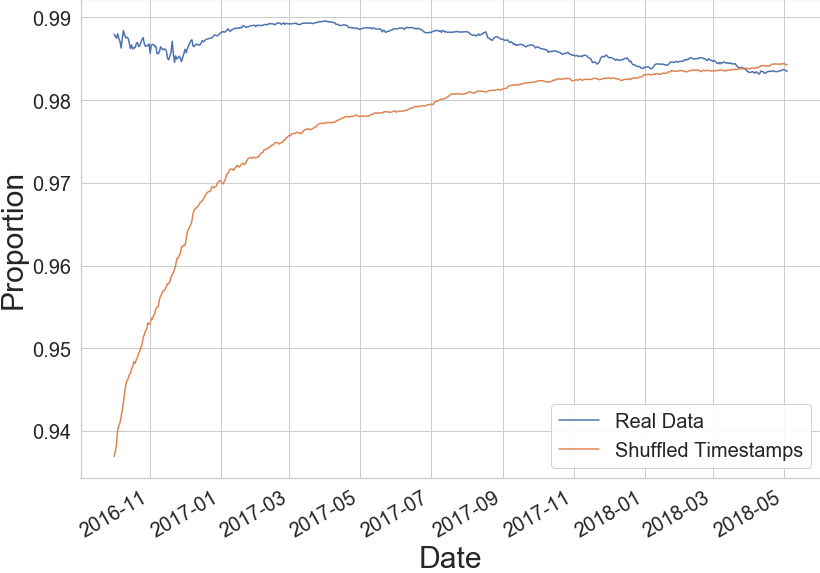

In [34]:
nullComparePlot('proportionWithoutIslands','Date','Proportion','linear','2016-09-30 23:00:00','2018-10-30','Year')

### Raw size of LCC: Hour window

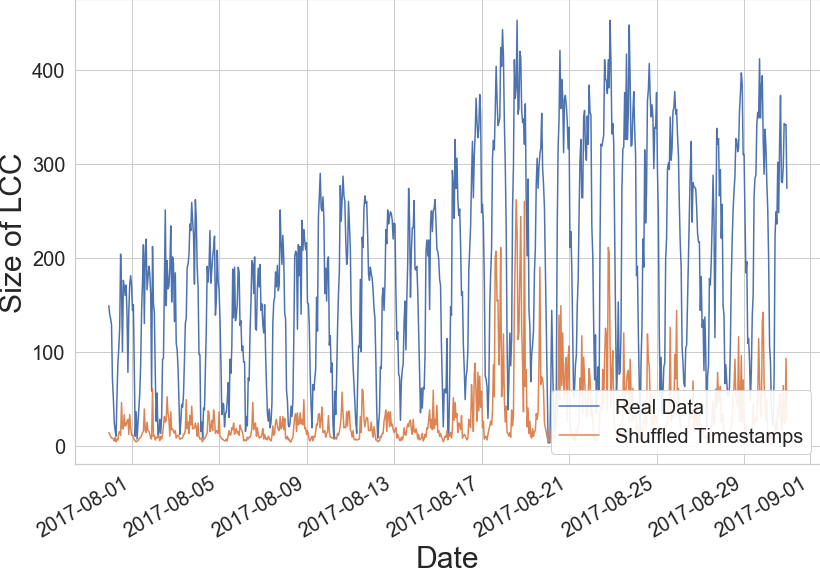

In [39]:
nullComparePlot('biggest','Date','Size of LCC','linear','2017-07-30 23:00:00','2017-08-30','Hour')

### Raw size of LCC: Day window

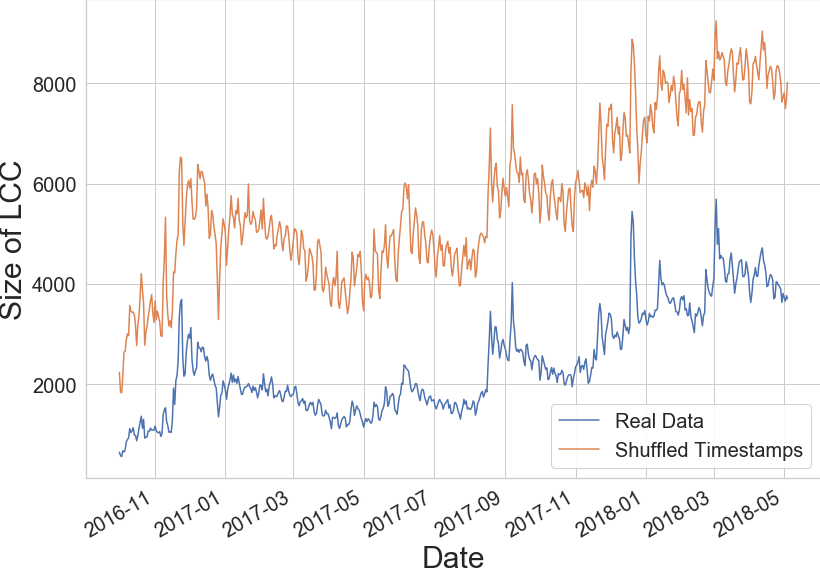

In [40]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Day')

### Raw size of LCC: Week window

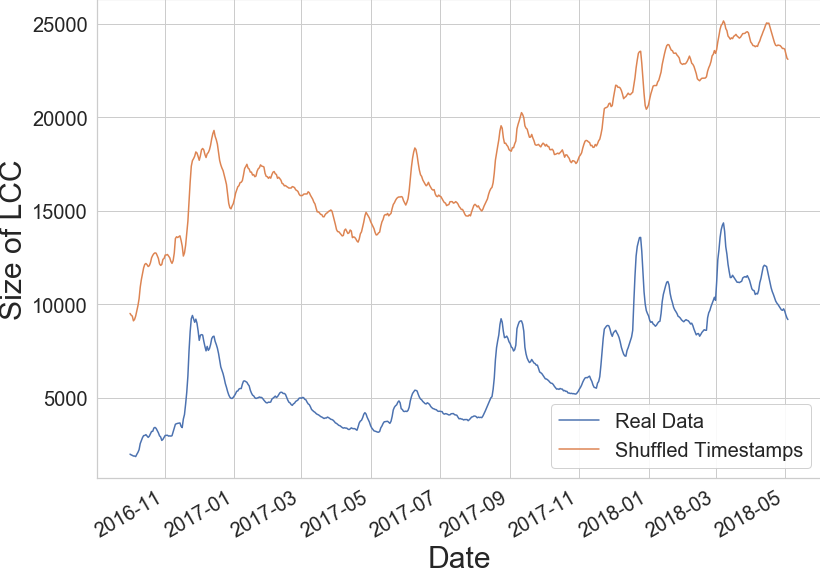

In [41]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Week')

### Raw size of LCC: Month window

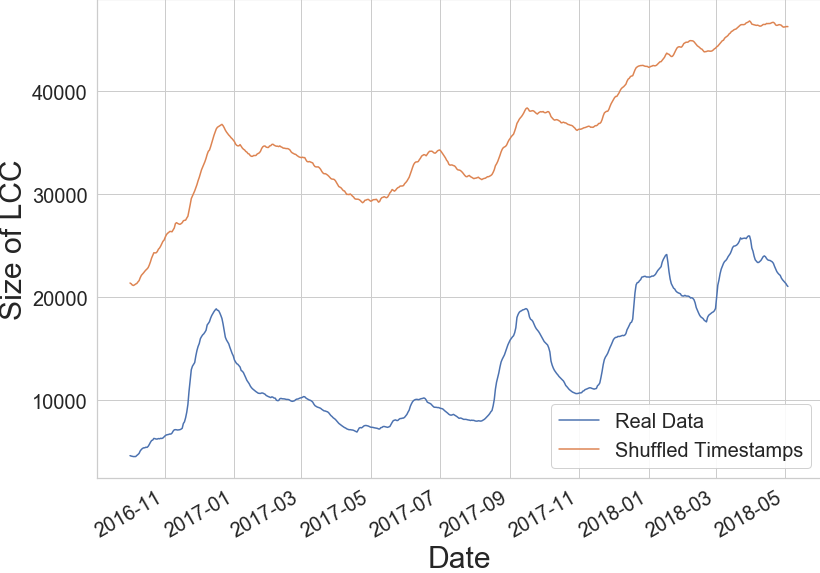

In [42]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Month')

### Raw size of LCC: Year window

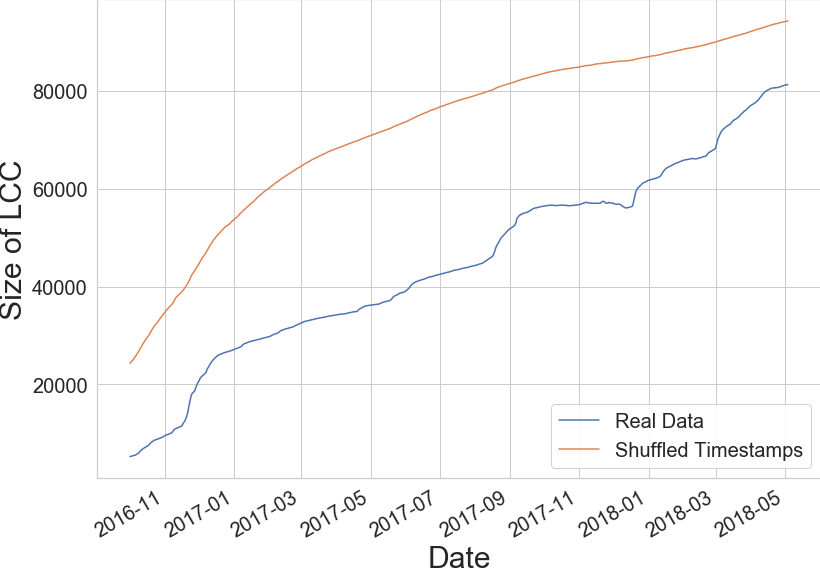

In [43]:
nullComparePlot('biggest','Date','Size of LCC','linear','2016-09-30 23:00:00','2018-10-30','Year')

## At which size does the giant component break?

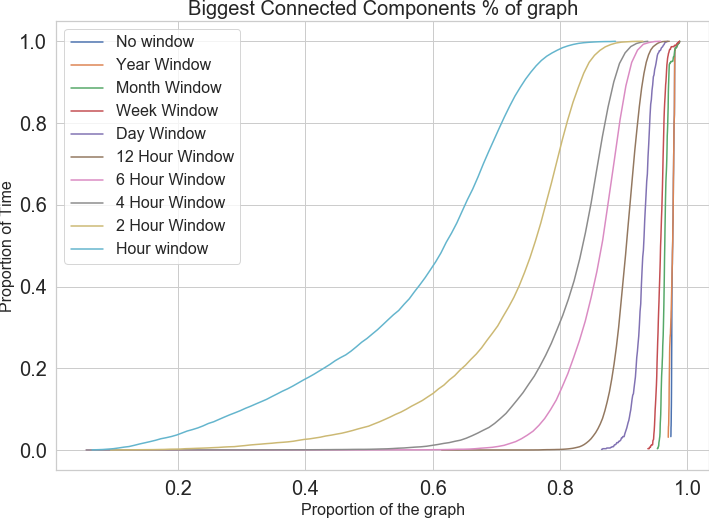

In [45]:
def proportionWindowCDFPlot(toPlot,title,x,y,scale,start,end):
    num_bins = 100
    
    windows = [31536000000,2592000000,604800000,86400000]
    windows2 = [43200000,21600000,14400000,7200000]
    labels = ["Year Window",'Month Window','Week Window','Day Window']
    labels2 = ["12 Hour Window","6 Hour Window","4 Hour Window","2 Hour Window"]
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title(title,fontsize=20)
    plt.xlabel(x,fontsize=16)
    plt.ylabel(y,fontsize=16)
    ax.set_yscale(scale)

    with open('CC/nowindow.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x = x[x['total'] != 0]
        x['mean'] = x[toPlot].rolling(window=4,center=False).mean()
        counts, bin_edges = np.histogram (x[toPlot], bins=num_bins, normed=True)
        cdf = np.cumsum (counts)
        l,=plt.plot (bin_edges[1:], cdf/cdf[-1])
        l.set_label("No window")

    with open('CC/bigCC.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        cc1 = cc1[cc1[toPlot] != 0]
        index = 0
        for i in windows:
            y = cc1[cc1['windowsize'] == i]
            y['mean'] = y[toPlot].rolling(window=4,center=False).mean()
            hours = str(int((i/3600000)))+" hour window"
            counts, bin_edges = np.histogram (y[toPlot], bins=num_bins, normed=True)
            cdf = np.cumsum (counts)
            l,=plt.plot (bin_edges[1:], cdf/cdf[-1])
            l.set_label(labels[index])
            index +=1

    with open('CC/ccwindowsecondset.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        cc1 = cc1[cc1[toPlot] != 0]
        index = 0
        for i in windows2:
            y = cc1[cc1['windowsize'] == i]
            y['mean'] = y[toPlot].rolling(window=4,center=False).mean()
            hours = str(int((i/3600000)))+" hour window"
            counts, bin_edges = np.histogram (y[toPlot], bins=num_bins, normed=True)
            cdf = np.cumsum (counts)
            l,=plt.plot (bin_edges[1:], cdf/cdf[-1])
            l.set_label(labels2[index])
            index +=1

    with open('CC/cc1hour.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x = x[x['total'] != 0]
        x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
        counts, bin_edges = np.histogram (x[toPlot], bins=num_bins, normed=True)
        cdf = np.cumsum (counts)
        plt.plot(bin_edges[1:], cdf/cdf[-1],label="Hour window")
        #x.plot(x='time', y=toPlot,ax=ax, color="#f0134d",)
    ax.legend(fontsize=16)
    plt.savefig("Graphs/ConnectedComponentsCDF.png")
    plt.show()



proportionWindowCDFPlot('proportion','Biggest Connected Components % of graph','Proportion of the graph','Proportion of Time','linear','2016-09-01', '2018-05-03')


        



## Diurnal activity as shown by the hourly window boxplots.

Needs attention regarding outlier calculations.

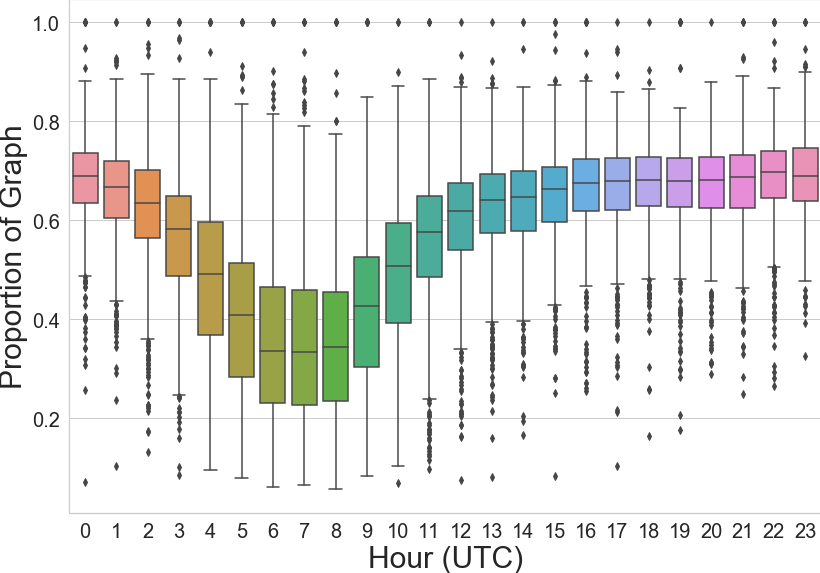

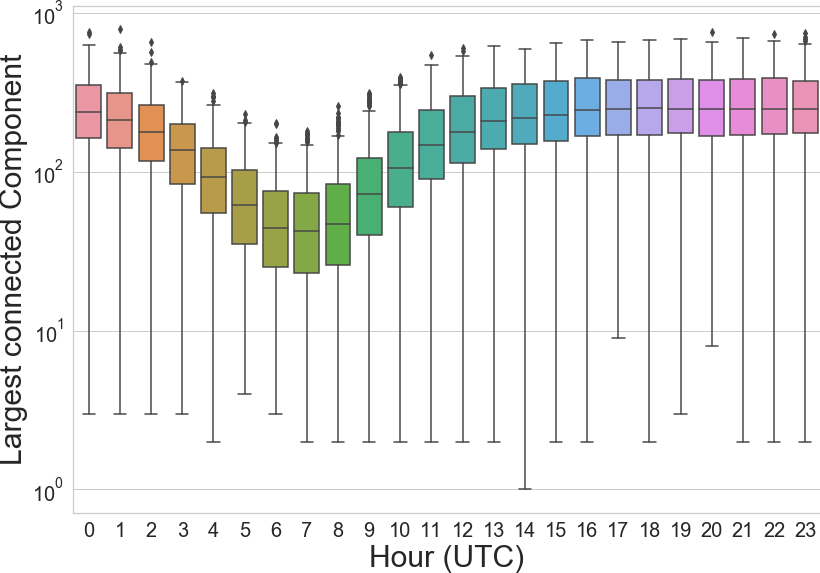

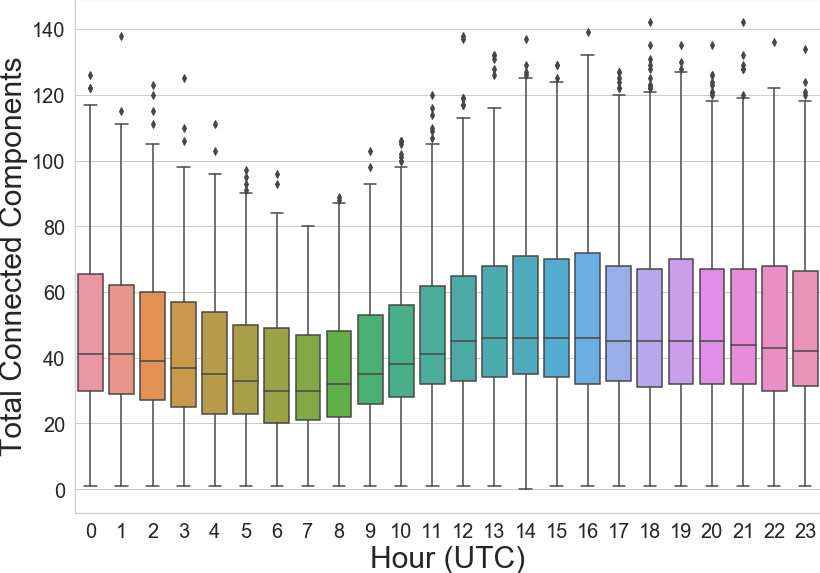

In [5]:
def diurnal_plot(toPlot, title, x, y, scale):
    windows = [31536000000,2592000000,604800000,86400000]
    start = 1483228800000
    no_weeks = 10
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(1,1,figsize=a4_dims)
    #ax[0].set_title(title,fontsize=20)
    #ax.set_title("Boxplot of "+title,fontsize=30)
    #ax[0].set_xlabel(x,fontsize=20)
    ax.set_xlabel(x,fontsize=30)
    #ax[0].set_ylabel(y,fontsize=20)
    ax.set_ylabel(y,fontsize=30)
    #ax[0].set_yscale(scale)
    ax.set_yscale(scale)
    
    dfs = {}
    
    with open('CC/cc1hour.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x = x.set_index('time')
        x['Weekday Name'] = x.index.weekday_name
        x['Hour'] = x.index.hour
    #print(x.dtypes)
        x = x[x['total'] != 0]
        means = x.groupby(x.index.hour).mean()
        sds = x.groupby(x.index.hour).std()
        #ax[0].plot(means['Hour'],means[toPlot])
        #ax[0].fill_between(means['Hour'], means[toPlot]-sds[toPlot]/2.0, means[toPlot]+sds[toPlot]/2.0, alpha=0.3)
        
        ax=sns.boxplot(data=x, x='Hour', y=toPlot)
        plt.xlabel("Hour (UTC)")
        plt.rc('xtick',labelsize=20)
        plt.rc('ytick',labelsize=20)
        plt.ylabel(y,fontsize=30)
        plt.tight_layout()
        plt.savefig("Graphs/"+y.replace(" ","_")+".png")
        plt.show()
        
diurnal_plot('proportion','Largest Connected Component % of graph','Hour','Proportion of Graph','linear')
diurnal_plot('biggest','Largest Connected Component Size','Hour','Largest connected Component','log')
diurnal_plot('totalWithoutIslands','Total Connected Components','Hour','Total Connected Components','linear')

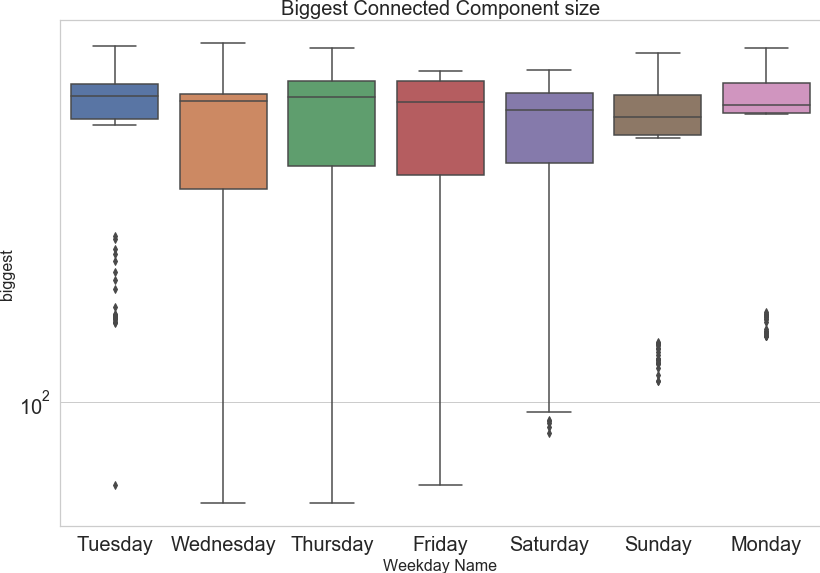

In [6]:
def weekly_plot(toPlot, title, x, y, scale):
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title(title,fontsize=20)
    plt.xlabel(x,fontsize=16)
    plt.ylabel(y,fontsize=16)
    ax.set_yscale(scale)
    
    daywindow=86400000
    
    with open('CC/cc.json') as json_file:
        cc1 = json.load(json_file)
        json_file.close()
        
    cc1= pd.DataFrame(cc1['views'])
    cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
    cc1 = cc1[cc1['total'] != 0]
    data = cc1[cc1['windowsize'] == daywindow]
    data = data.set_index('time')
    data['Weekday Name'] = data.index.weekday_name
    data = data[data['total']!=0]
    means = data.groupby(data.index.weekday_name).mean()
    sds = data.groupby(data.index.weekday_name).std()     

    ax=sns.boxplot(data=data, x='Weekday Name', y=toPlot)
    #ax.fill_between(means.index, means[toPlot]-sds[toPlot]/2.0, means[toPlot]+sds[toPlot]/2.0, alpha=0.3)
    
    #plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.savefig("Graphs/Weekday_"+y.replace(" ","_")+".png")
    plt.show()
    
#weekly_plot('proportion','Biggest Connected Components % of graph','Weekday Name','Proportion of Graph','linear')

weekly_plot('biggest','Biggest Connected Component size','Weekday Name','Largest connected Component','log')

#weekly_plot('totalWithoutIslands','Total Connected Components','Weekday Name','Total Connected Components','linear') 

# Dynamics of top 20 users

For each window size and window, we obtain the top 20 users in terms of in-degree. Is it the case that some users dominate for long periods, or is it more dynamic?

### Jaccard Similarity.

For two sets A and B, the Jaccard similarity is given by |A n B| / |A u B| measuring their percentage overlap.

In [46]:
def jaccard_similarity(list1, list2):
    list1, list2 = set(list1), set(list2)
    intersection_size = len(list1.intersection(list2))
    union_size=len(list1)+len(list2)-intersection_size
    if union_size==0:
        return 0.0
    else: return intersection_size/union_size

## Stability over consecutive windows

For each window size, we calculate the Jaccard similarity between the pairs of consecutive non-overlapping windows' top 20 users. 

[0.         0.44928546 0.4808423  0.35890023 0.21373447]
[0.         0.17999554 0.13703931 0.0882071  0.0853066 ]


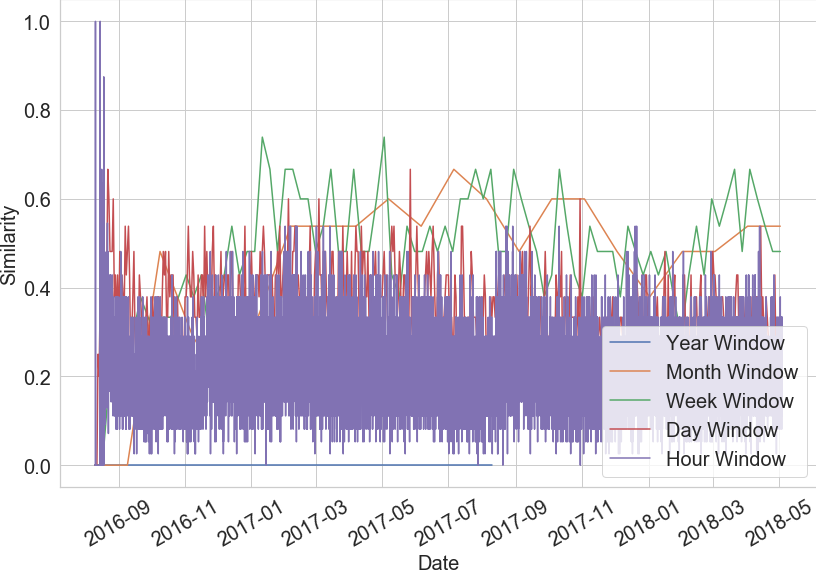

['Hour Window', 'Day Window', 'Week Window', 'Month Window', 'Year Window']


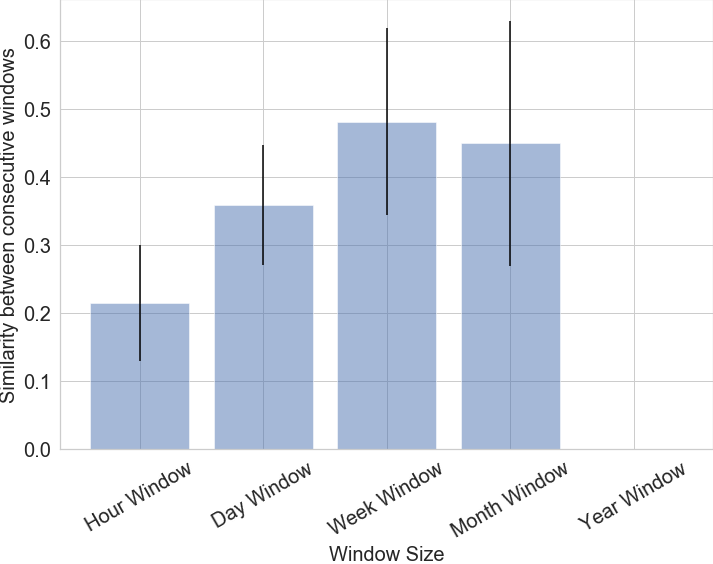

In [49]:
def get_users(cell):
    if len(cell)==0:
        return []
    return pd.DataFrame(cell)['id']

def rank_jaccard_fast(x, y, title, scale):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window', 'Hour Window']
    a4_dims = (11.7, 8.27)
    day_length=86400000
    fig, ax = plt.subplots(figsize=a4_dims)
    jaccard=pd.DataFrame({'Window Size':[], 'Jaccard':[]})
    #plt.title(title, size=30)
    plt.xlabel(x, size=20)
    plt.ylabel(y, size=20)
    ax.set_yscale(scale)
    
    means=np.zeros(5)
    sds=np.zeros(5)
    
    with open('degree/degreewindows.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    index = 0
    for i in windows:
        n = round(i/day_length)
        y = degs[degs['windowsize'] == i]
        y = y.iloc[::n,:]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        y['nexttop'] = y['topusers'].shift(1)
        y['nexttop'][0]=[]
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
        means[index]=np.mean(y['jaccard'])
        sds[index]=np.std(y['jaccard'])
        jaccard['Time']=y['time']
        jaccard[labels[index]]=y['jaccard']
        
        ax.plot(y['time'],y['jaccard'], label=labels[index])
        index +=1
    
    jaccard.set_index('Time',inplace=True)
    
    with open('degree/degreehours.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
    
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    y = degs
    y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    y['nexttop'] = y['topusers'].shift(1)
    y['nexttop'][0]=[]

    y['jaccard']= y.apply(lambda x: 0.0, axis=1)
    y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
    means[index]=np.mean(y['jaccard'])
    sds[index]=np.std(y['jaccard'])
    jaccard['Time']=y['time']
    jaccard[labels[index]]=y['jaccard']

    ax.plot(y['time'],y['jaccard'], label=labels[index])
    
    print(means)
    print(sds)

    plt.legend(fontsize=20, loc='lower right')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarity.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=a4_dims)
    windows = [31536000000,2592000000,604800000,86400000,3600000]
    windows.reverse()

    new_means = np.flip(means)
    new_sds = np.flip(sds)
    
    labels.reverse()
    print(labels)
    ax.bar(np.arange(5), new_means, yerr=new_sds, align='center', alpha=0.5, ecolor='black')
    plt.xlabel('Window Size',size=20)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels,size=20,rotation=30)
    plt.ylabel('Similarity between consecutive windows', size=20)
    plt.savefig('Graphs/JaccardMeanSD.png')
    plt.show()
    
    
rank_jaccard_fast("Date", "Similarity", "Jaccard similarity index of consecutive node rankings", 'linear')

## Effect of shuffling timestamps

As with the connected components, we look at the effect of randomly shuffling the timestamps. It seems to have a "smoothing effect", suggesting that in the original data, many of the users who reach the top 20 may only do so for a short period of time.

[0.         0.87052342 0.8693952  0.63457222 0.12076518]
[0.         0.28023836 0.16617867 0.14761091 0.07694133]


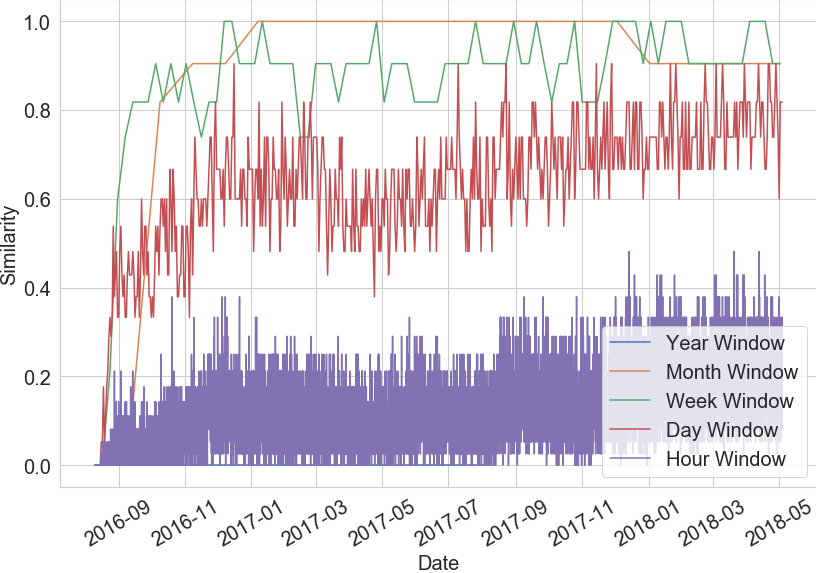

['Hour Window', 'Day Window', 'Week Window', 'Month Window', 'Year Window']


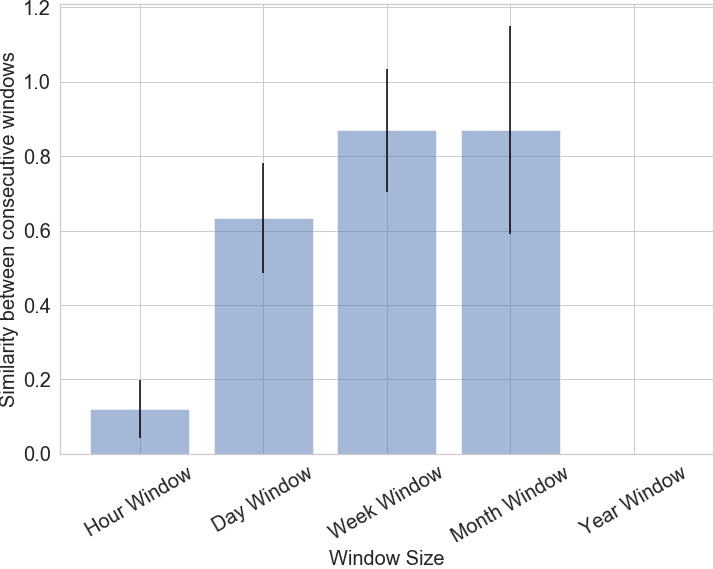

In [50]:
def rank_jaccard_shuffled(x, y, title, scale):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window', 'Hour Window']
    a4_dims = (11.7, 8.27)
    day_length=86400000
    fig, ax = plt.subplots(figsize=a4_dims)
    jaccard=pd.DataFrame({'Window Size':[], 'Jaccard':[]})
    #plt.title(title, size=30)
    plt.xlabel(x, size=20)
    plt.ylabel(y, size=20)
    ax.set_yscale(scale)
    
    means=np.zeros(5)
    sds=np.zeros(5)
    
    with open('degree/degreesorted.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    index = 0
    for i in windows:
        n = round(i/day_length)
        y = degs[degs['windowsize'] == i]
        y = y.iloc[::n,:]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        y['nexttop'] = y['topusers'].shift(1)
        y['nexttop'][0]=[]
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
        means[index]=np.mean(y['jaccard'])
        sds[index]=np.std(y['jaccard'])
        jaccard['Time']=y['time']
        jaccard[labels[index]]=y['jaccard']
        
        ax.plot(y['time'],y['jaccard'], label=labels[index])
        index +=1
    
    jaccard.set_index('Time',inplace=True)
    
    with open('degree/degreesortedhour.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
    
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    y = degs
    y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    y['nexttop'] = y['topusers'].shift(1)
    y['nexttop'][0]=[]

    y['jaccard']= y.apply(lambda x: 0.0, axis=1)
    y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],row['nexttop']), axis=1)
    means[index]=np.mean(y['jaccard'])
    sds[index]=np.std(y['jaccard'])
    jaccard['Time']=y['time']
    jaccard[labels[index]]=y['jaccard']

    ax.plot(y['time'],y['jaccard'], label=labels[index])
    
    print(means)
    print(sds)

    plt.legend(fontsize=20, loc='lower right')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarityShuffled.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=a4_dims)
    windows = [31536000000,2592000000,604800000,86400000,3600000]
    windows.reverse()

    new_means = np.flip(means)
    new_sds = np.flip(sds)
    
    labels.reverse()
    print(labels)
    ax.bar(np.arange(5), new_means, yerr=new_sds, align='center', alpha=0.5, ecolor='black')
    plt.xlabel('Window Size',size=20)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels,size=20,rotation=30)
    plt.ylabel('Similarity between consecutive windows', size=20)
    plt.savefig('Graphs/JaccardMeanSDShuffled.png')
    plt.show()
    
    
rank_jaccard_shuffled("Date", "Similarity", "Jaccard similarity index of consecutive node rankings", 'linear')

31536000000
2592000000
604800000
86400000


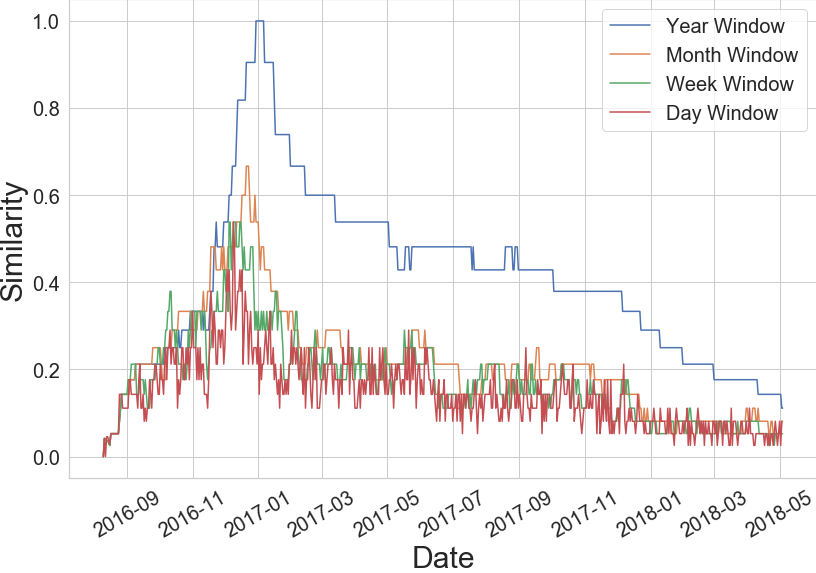

In [12]:
def get_users(cell):
    if len(cell)==0:
        return []
    return pd.DataFrame(cell)['id']

def rank_jaccard_year_comparison(x, y, title, scale):
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    jaccard=pd.DataFrame({'Window Size':[], 'Jaccard':[]})
    #plt.title(title, size=30)
    plt.xlabel(x, size=30)
    plt.ylabel(y, size=30)
    ax.set_yscale(scale)
    
    with open('degree/degreewindows.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    #get year comparison:
    year = degs[degs['windowsize']==31536000000]
    jan17top = get_users(year['bestusers']['2017-01-01 23:00:00'])
    
    index=0
    for i in windows:
        print(i)
        y = degs[degs['windowsize'] == i]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
    
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(row['topusers'],jan17top), axis=1)
        
        ax.plot(y['time'],y['jaccard'], label=labels[index])
        index +=1        
        
    plt.legend(fontsize=20, loc='upper right')
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarityJan17.png')
    plt.show()        
    
rank_jaccard_year_comparison('Date','Similarity','Similarity','linear')

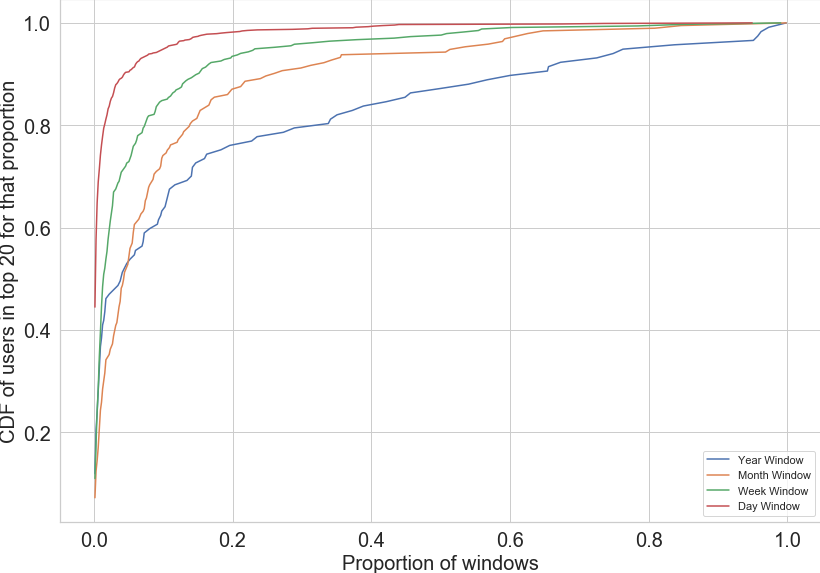

In [18]:
from collections import Counter
from itertools import chain

def how_many_windows(x,y,title,scale):
    
    windows = [31536000000,2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title, size=30)
    plt.xlabel(x, size=20)
    plt.ylabel(y, size=20)
    ax.set_yscale(scale)
    
    with open('degree/degreewindows.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    index = 0
    for i in windows:
        y = degs[degs['windowsize'] == i]
        total_windows = len(y)
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        users_count = Counter(chain.from_iterable(set(row) for row in y['topusers']))
        meta = Counter(users_count.values())
        x1,y1 = zip(*sorted(meta.items()))
        x1 = np.array(x1)/total_windows
        y1 = np.cumsum(np.array(y1))/len(users_count.items())
        cdf = 1-y1
        ax.plot(x1,y1, label=labels[index])
        index+=1
        
    plt.legend()
    plt.tight_layout()
    plt.show()
    
how_many_windows('Proportion of windows','CDF of users in top 20 for that proportion','lol','linear')

In [ ]:
def get_users(cell):
    if len(cell)==0:
        return []
    return pd.DataFrame(cell)['id']
def rank_jaccard_year_comparison(x, y, title, scale):
    windows = [2592000000,604800000,86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    jaccard=pd.DataFrame({'Window Size':[], 'Jaccard':[]})
    #plt.title(title, size=30)
    plt.xlabel(x, size=20)
    plt.ylabel(y, size=20)
    ax.set_yscale(scale)
    
    with open('degree/degreewindows.json') as json_file:
        degs = json.load(json_file)
        json_file.close()
        
    degs = pd.DataFrame(degs['views'])
    degs['time'] = pd.to_datetime(degs['time'],unit='ms')
    degs['index'] = pd.to_datetime(degs['time'],unit='ms')
    degs.set_index('index', inplace=True)
    
    #get year comparison:
    year = degs[degs['windowsize']==31536000000]
    year['topusers']=year.apply(lambda row: get_users(row['bestusers']),axis=1)   
    index=0
    for i in windows:
        print(i)
        y = degs[degs['windowsize'] == i]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        y['jaccard']= y.apply(lambda x: 0.0, axis=1)
        y['jaccard'] = y.apply(lambda row: jaccard_similarity(y['topusers'],year['topusers'][index]), axis=1)
        
        ax.plot(y['time'],y['jaccard'], label=labels[index])
        index +=1        
        
    plt.legend(fontsize=20, loc='upper right')
    plt.tight_layout()
    plt.savefig('graphs/JaccardSimilarityJan17.png')
    plt.show()        
    
rank_jaccard_year_comparison('Date','Similarity','Similarity','linear')

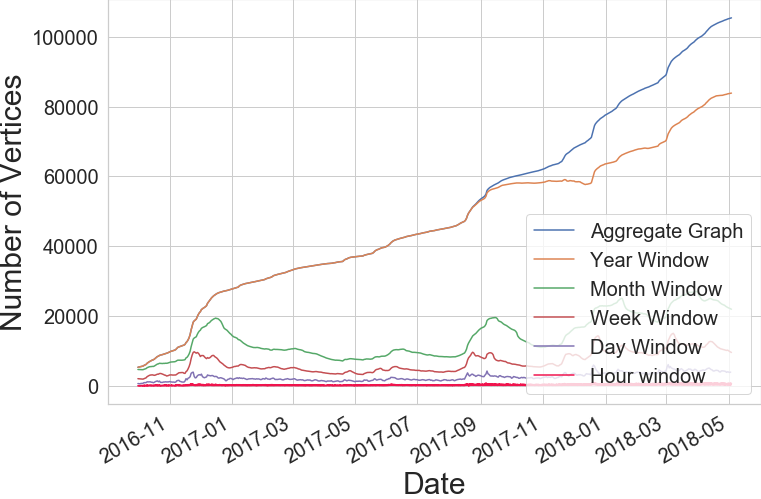

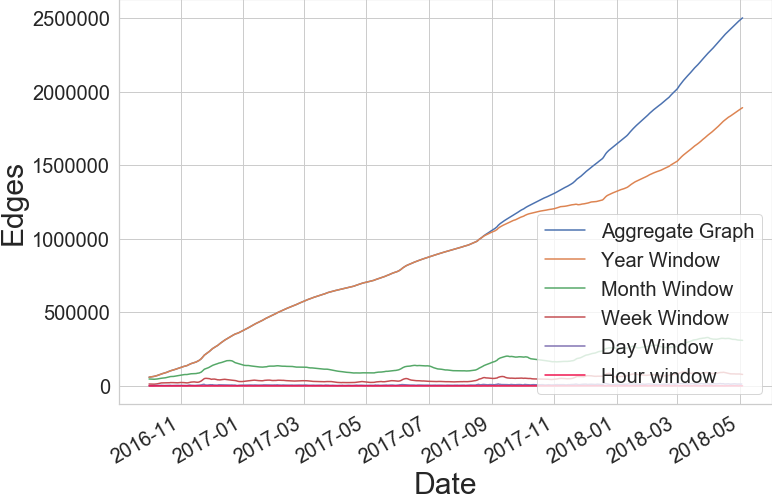

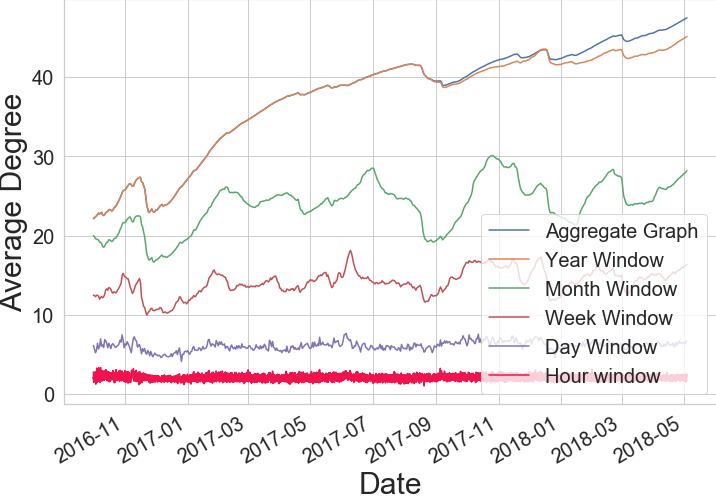

In [5]:
def fullPlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000, 86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)

    with open('degree/degrees.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        x = x[x[toPlot] != 0]
        x.plot(x='time', y=toPlot,ax=ax, label="Aggregate Graph")

    with open('degree/degreewindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        index = 0
        for i in windows:
            y = cc1[cc1['windowsize'] == i]
            y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
            #y = y[y[toPlot] != 0]
            y.plot(x='time', y=toPlot,ax=ax, label=labels[index])
            index +=1

    with open('degree/degreehours.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
        x = x[x[toPlot] != 0]
        x.plot(x='time', y=toPlot,ax=ax, color="#f0134d", label="Hour window")
        
    #plt.axvline('2016-11-09',linestyle='')
    #plt.axvline('2017-08-11')
    #plt.axvline('2017-08-13')
    plt.legend(fontsize=20, loc='lower right')
    plt.xlabel('Date',fontsize=30)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.savefig('graphs/'+toPlot+'.png')
    plt.show()

#x['mean'] = x[toPlot].rolling(window=24,center=False).mean()
#[0,4,8,12,16,20,24]
#'2016-07-01': '2018-05-03'
fullPlot('vertices','Total Number of Vertices','Date','Number of Vertices','linear','2016-09-30 23:00:00','2018-10-30')
fullPlot('edges', 'Total Number of Edges', 'Date', 'Edges', 'linear','2016-09-30 23:00:00','2018-10-30')
fullPlot('avgdeg', 'Average Degree', 'Date', 'Average Degree', 'linear','2016-09-30 23:00:00','2018-10-30')

#fullPlot('biggest','Biggest Connected Component size','Date','Largest connected Component','log','2016-09-30 23:00:00','2018-10-30')

#fullPlot('totalWithoutIslands','Total Connected Components','Date','Total Connected Components','linear')

#fullPlot('clustersGT2','Total Connected Components with a size > 2','Date','Total Connected Components with size > 2','linear')


Empty DataFrame
Columns: [time, windowsize, vertices, edges, degree, bestusers, viewTime, concatTime]
Index: []


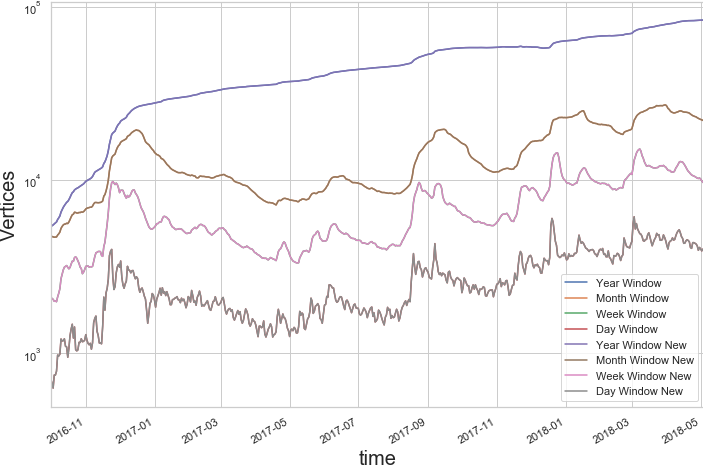

In [11]:
def fullPlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000, 86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    labels2 = ['Year Window New','Month Window New','Week Window New','Day Window New']

    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=20)
    plt.ylabel(y,fontsize=20)
    ax.set_yscale(scale)

    old = 0
    new = 0
    
    with open('degree/degreewindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        old = cc1
        index = 0
        for i in windows:
            y = cc1[cc1['windowsize'] == i]
            #y = y[y[toPlot] != 0]
            y.plot(x='time', y=toPlot,ax=ax, label=labels[index])
            index +=1
            
    with open('degree/degreewindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='ms')
        cc1.set_index('index', inplace=True)
        cc1=cc1[start:end]
        index = 0
        new = cc1
        for i in windows:
            y = cc1[cc1['windowsize'] == i]
            #y = y[y[toPlot] != 0]
            y.plot(x='time', y=toPlot,ax=ax, label=labels2[index])
            index +=1
    y = old[old['edges']!=new['edges']]
    print(y)
    #plt.axvline('2016-11-09',linestyle='')
    #plt.axvline('2017-08-11')
    #plt.axvline('2017-08-13')
    #plt.legend(fontsize=20, loc='lower right')
    #plt.xlabel('Date',fontsize=20)
    #plt.savefig('graphs/'+toPlot+'.png')
    #plt.show()

#x['mean'] = x[toPlot].rolling(window=24,center=False).mean()
#[0,4,8,12,16,20,24]
#'2016-07-01': '2018-05-03'
fullPlot('vertices','Total Number of Vertices','Date','Vertices','log','2016-09-30 23:00:00','2018-10-30')

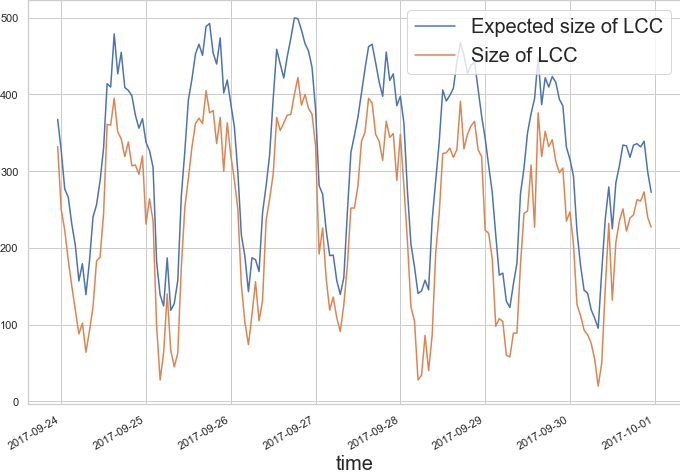

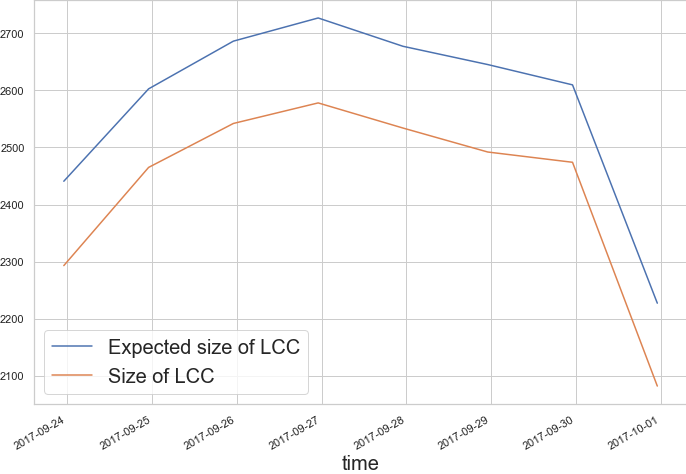

In [245]:
# Size of largest connected component compared to expected in an E-R Graph

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)
plt.xlabel('Time',fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
ax.set_yscale('linear')

import networkx as nx

def get_expected_size(n,m):
    sizes=np.zeros(5)
    for i in range(5):
        G = nx.gnm_random_graph(n, m)
        largest = max(nx.connected_component_subgraphs(G), key=len)
        sizes[i]=len(largest)
    return np.mean(sizes)

start, end = '2017-9-23 23:00:00','2017-09-30 23:00:00'

with open('degree/degreehours.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['mean'] =x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #plt.fill_between(x['time'],np.array(x['mean'])-np.array(x['sd']), np.array(x['mean'])+np.array(x['sd']),alpha=0.3)
    #print(x['expected'])
    ax.plot(x['time'],x['mean'],label='Expected size of LCC')
    json_file.close()
    
with open('CC/cc1hour.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()

plt.legend(fontsize=20)
plt.savefig("Graphs/largest_vs_expected_hour.png")
plt.title("Hour Window")
plt.show()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)
plt.xlabel('',fontsize=20)
ax.set_yscale('linear')

with open('degree/degreewindows.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==86400000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['mean'] =x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #print(x['expected'])
    #ax.fill_between(x['time'],np.array(x['mean'])-np.array(x['sd']), np.array(x['mean'])+np.array(x['sd']),alpha=0.3)
    ax.plot(x['time'],x['mean'],label='Expected size of LCC')
    json_file.close()
    
with open('CC/bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==86400000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()
    
plt.legend(fontsize=20)
plt.show()

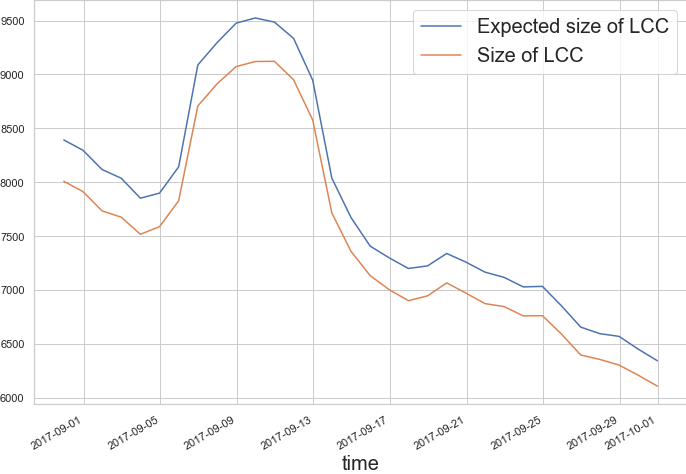

In [221]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)
plt.xlabel('Time',fontsize=20)
ax.set_yscale('linear')

with open('degree/degreewindows.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==604800000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['expected']=x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #print(x['expected'])
    x.plot(x='time',y='expected',ax=ax,label='Expected size of LCC')
    json_file.close()
    
with open('CC/bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==604800000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()
    
plt.legend(fontsize=20)
plt.show()

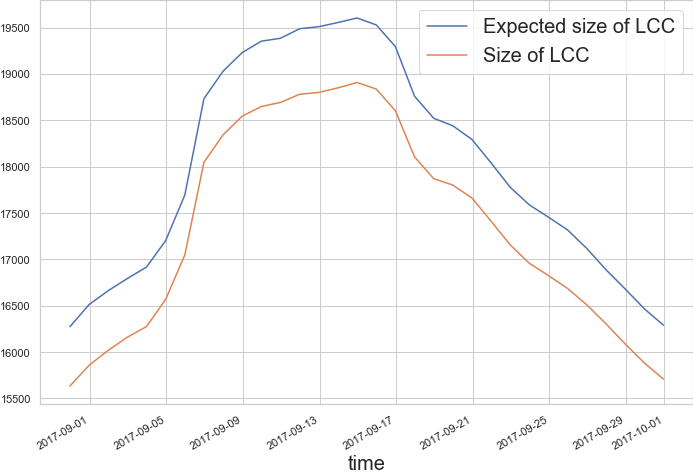

In [222]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.title(title,fontsize=30)
plt.xlabel('Time',fontsize=20)
ax.set_yscale('linear')

with open('degree/degreewindows.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==2592000000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x['expected']=x.apply(lambda row : get_expected_size(row['vertices'],row['edges']),axis=1)
    #print(x['expected'])
    x.plot(x='time',y='expected',ax=ax,label='Expected size of LCC')
    json_file.close()
    
with open('CC/bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x=x[x['windowsize']==2592000000]
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    x.plot(x='time',y='biggest',ax=ax, label='Size of LCC')
    json_file.close()
    
plt.legend(fontsize=20)
plt.show()

# Time Series Analysis of Giant Component

This section will explore whether there is periodic behaviour in the size/proportion of giant component size.

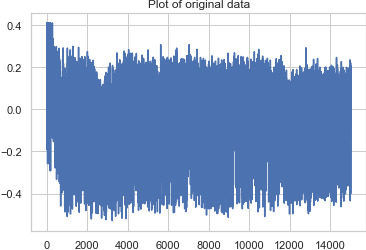

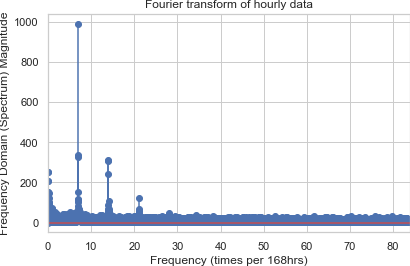

In [179]:
# Look at power spectrum of proportion data
from scipy import fftpack, signal


with open('CC/cc1hour.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    json_file.close()
    
data_prop = signal.detrend(np.array(x['proportion']),)

# plot original data (shifted by mean)

plt.plot(range(len(data_prop)),data_prop)
plt.title('Plot of original data')
plt.show()

# get fourier series
fs = 168
x = fftpack.fft(data_prop)
# x is a vector of complex number eigenvalues
freqs = fftpack.fftfreq(len(data_prop))*fs

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(x))
ax.set_xlabel('Frequency (times per '+str(fs)+'hrs)')
ax.set_xlim(0,0.5*fs)
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
plt.title('Fourier transform of hourly data')
plt.tight_layout()
plt.show()

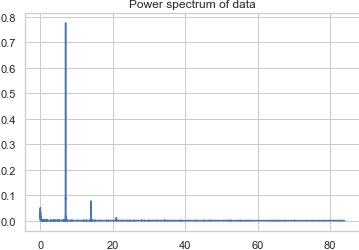

In [180]:
# Compute power spectrum for clearer picture
freqs, P_xx = signal.periodogram(data_prop, fs, scaling = 'density')
plt.plot(freqs, P_xx)
plt.title('Power spectrum of data')
plt.show()

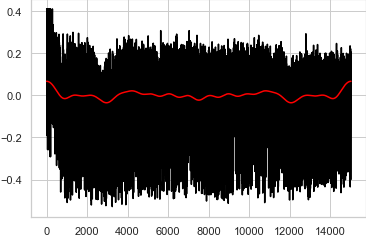

In [181]:
# Compute inverse fourier transform of first few frequencies.

tmp = np.zeros(len(x))
tmp[:20]=x[:20]
IFT = fftpack.ifft(tmp)
plt.plot(range(len(data_prop)),data_prop, color='black')
plt.plot(range(len(data_prop)),IFT,color='red')
plt.show()

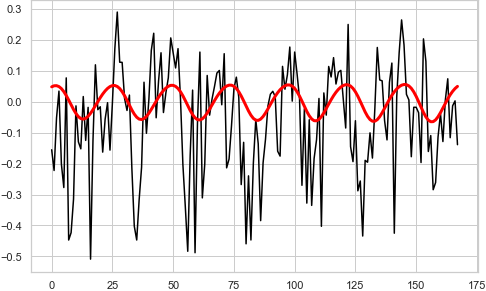

In [182]:
#First 10 harmonics against real data for 1 week

ix_full = np.argsort(-1*np.absolute(x))
res_full = np.absolute(x[ix_full])

tmp = np.zeros(len(x),dtype=np.complex)
tmp[ix_full[:10]]=x[ix_full[:10]]
res1 = np.fft.ifft(tmp)

plt.figure(figsize=(8,5))
plt.plot(range(168),data_prop[1000:1168],color='black')
plt.plot(range(168),res1[1000:1168],color='red',linewidth=3)
plt.show()

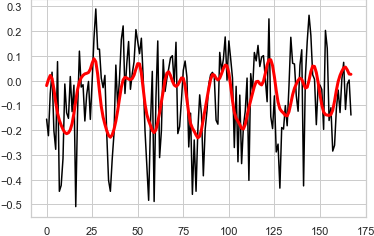

In [183]:
#First 240 harmonics

tmp = np.zeros(len(x), dtype=np.complex)
tmp[ix_full[:240]]=x[ix_full[:240]]
res2 = np.fft.ifft(tmp)

plt.plot(data_prop[1000:1168],color='black')
plt.plot(np.real(res2[1000:1168]),color='red',linewidth=3)
plt.show()

[ 0.18639738  0.18412979  0.1957613  ... -0.09014742 -0.13539025
 -0.09789462]


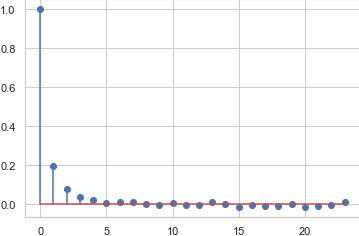

In [185]:
# See if lagged series without harmonics is still correlated.

without_harmonics = data_prop - np.real(res2)

plt.stem(range(24), acf(without_harmonics,24))
plt.show()

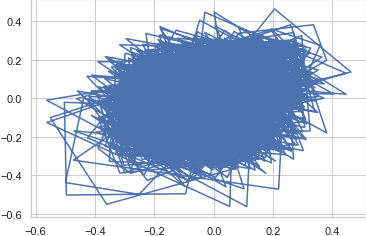

In [186]:
# Look at the 4-lagged version of noise
without_harmonics_lagged = np.roll(without_harmonics,1)

plt.plot(without_harmonics, without_harmonics_lagged)
plt.show()

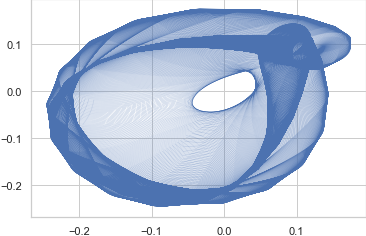

In [187]:
# Look at the 4-lagged version of cleaned signal
res1_lagged = np.roll(np.real(res1),4)

plt.plot(np.real(res1), res1_lagged, linewidth=0.1)
plt.show()

In [ ]:
# Try to find out more about the two peaks

In [188]:
# Let's do some the same process but this time with the "size of LCC" data

with open('CC/cc1hour.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    x =x[start:end]
    json_file.close()
    
data_biggest = signal.detrend(np.array(x['biggest']))

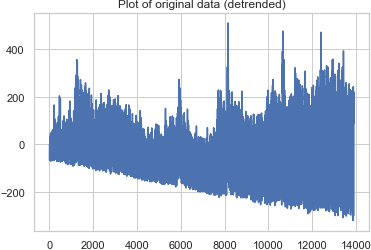

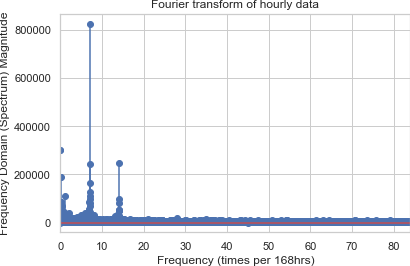

In [189]:
plt.plot(range(len(data_biggest)),data_biggest)
plt.title('Plot of original data (detrended)')
plt.show()

# get fourier series
fs = 168
y = fftpack.fft(data_biggest)
# x is a vector of complex number eigenvalues
freqs = fftpack.fftfreq(len(data_biggest))*fs

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(y))
ax.set_xlabel('Frequency (times per '+str(fs)+'hrs)')
ax.set_xlim(0,0.5*fs)
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
plt.title('Fourier transform of hourly data')
plt.tight_layout()
plt.show()

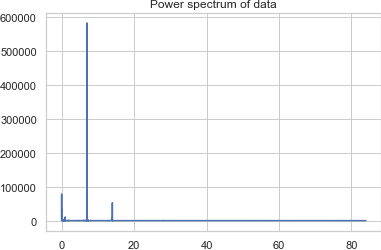

In [190]:
# Compute power spectrum for clearer picture
freqs, P_xx = signal.periodogram(data_biggest, fs, scaling = 'density')
plt.plot(freqs, P_xx)
plt.title('Power spectrum of data')
plt.show()

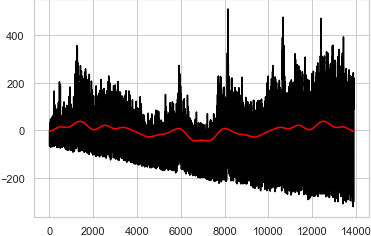

In [191]:
# Compute inverse fourier transform of first few frequencies.

tmp = np.zeros(len(y))
tmp[:20]=y[:20]
IFT = fftpack.ifft(tmp)
plt.plot(range(len(data_biggest)),data_biggest, color='black')
plt.plot(range(len(data_biggest)),IFT,color='red')
plt.show()

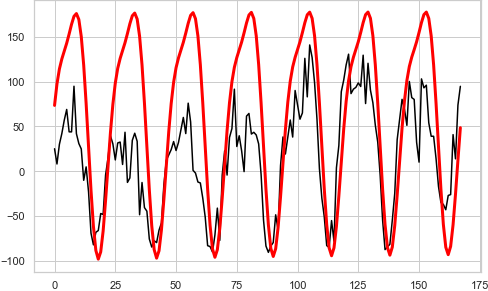

In [193]:
#First 10 harmonics against real data for 1 week

ix_full = np.argsort(-1*np.absolute(y))
res_full = np.absolute(y[ix_full])

tmp = np.zeros(len(y),dtype=np.complex)
tmp[ix_full[:10]]=y[ix_full[:10]]
res1 = np.fft.ifft(tmp)

plt.figure(figsize=(8,5))
plt.plot(range(168),data_biggest[1000:1168],color='black')
plt.plot(range(168),res1[1000:1168],color='red',linewidth=3)
plt.show()

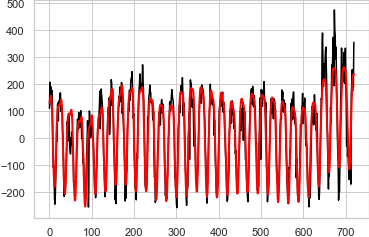

In [198]:
#First 240 harmonics

tmp = np.zeros(len(y), dtype=np.complex)
tmp[ix_full[:240]]=y[ix_full[:240]]
res2 = np.fft.ifft(tmp)

plt.plot(data_biggest[10000:10720],color='black')
plt.plot(np.real(res2[10000:10720]),color='red',linewidth=2)
plt.show()

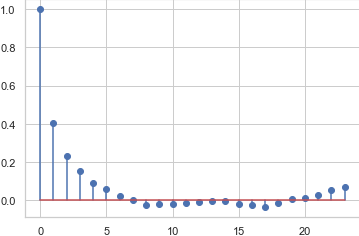

In [199]:
# See if lagged series without harmonics is still correlated.

without_harmonics = data_biggest - np.real(res2)

plt.stem(range(24), acf(without_harmonics,24))
plt.show()

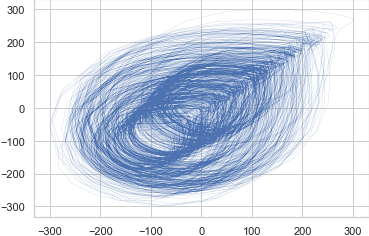

In [200]:
# Look at the 4-lagged version of cleaned signal
res1_lagged = np.roll(np.real(res2),4)

plt.plot(np.real(res2), res1_lagged, linewidth=0.1)
plt.show()

# OLD STUFF

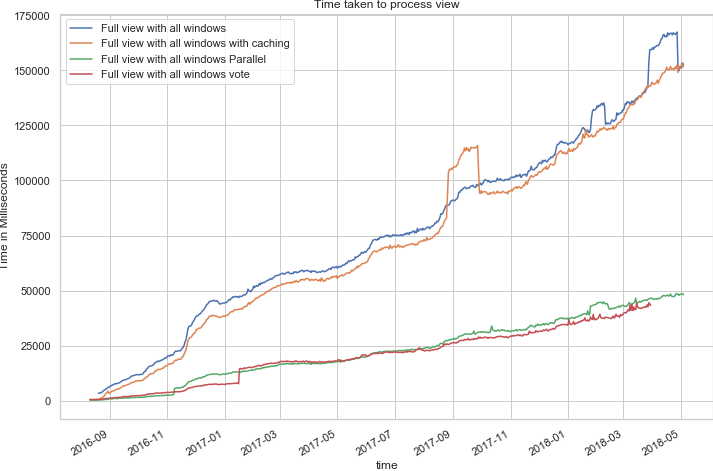

In [38]:



windows = [31536000000,2592000000,604800000,86400000]
with open('bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x = x[x['total'] != 0]
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title('Biggest Connected Components % of graph')
    plt.xlabel('Date')
    plt.ylabel('Proportion of Graph')
    for i in windows:
        y = x[x['windowsize'] == i]
        y['mean'] = y['proportion'].rolling(window=4,center=False).mean()
        hours = str(int((i/3600000)))+" hour window"
        y.plot(x='time', y='mean',ax=ax, label=hours)
    plt.show()





windows = [31536000000,2592000000,604800000,86400000]
y=0
x=0
z=0
a=0
with open('bigCC.json') as json_file:
    x = json.load(json_file)
    x= pd.DataFrame(x['views'])
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x = x[x['total'] != 0]
    
with open('bigCC2.json') as json_file:
    y = json.load(json_file)
    y= pd.DataFrame(y['views'])
    y['time'] = pd.to_datetime(y['time'],unit='ms')
    y = y[y['total'] != 0]
    
with open('bigCC3.json') as json_file:
    z = json.load(json_file)
    z = pd.DataFrame(z['views'])
    z['time'] = pd.to_datetime(z['time'],unit='ms')
    z = z[z['total'] != 0]
    
with open('bigCC4.json') as json_file:
    a = json.load(json_file)
    a = pd.DataFrame(a['views'])
    a['time'] = pd.to_datetime(z['time'],unit='ms')
    a = a[a['total'] != 0]
    

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Time taken to process view')
plt.xlabel('Date')
plt.ylabel('Time in Milliseconds')
x.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows")
y.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows with caching")
z.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows Parallel")
a.plot(x='time', y='viewTime',ax=ax, label="Full view with all windows vote")


plt.show()